# Assignment 2 Task 1

## Multilayer Perceptron Model - Single Vector Representation

In [1]:
from gensim.models import KeyedVectors
import re 
from gensim.scripts.glove2word2vec import glove2word2vec

import keras
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras import initializers
from keras import optimizers
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l1
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding

import matplotlib.pyplot as plt

import numpy as np
from numpy import loadtxt

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

import tensorflow

In [2]:
#Import train and test data
train_data = pd.read_csv('traindrug.csv',encoding = "ISO-8859-1")
test_data = pd.read_csv('testdrug.csv',encoding = "ISO-8859-1")
print (train_data)
print(test_data)

                                               Comment  Score
0    I have had nothing but problems with the Keppe...      1
1    I had terrible, terrible side effects. went in...      1
2    I'm naturally depressed/anxious, but this medi...      1
3    My experience on this medicine was Awful, to s...      1
4    As a heathcare professional having given Mucom...      1
..                                                 ...    ...
995  I was told by several doctors that I may be bi...      3
996  A couple of years ago I ended up with anxiety ...      3
997  I've had the Implanon for about 2 months now. ...      3
998  I was diagnosed with interstitial cystitis sev...      3
999  First day of Adipex.. My doctor wrote me a pre...      3

[1000 rows x 2 columns]
                                               Comment  Score
0    After 2 months on this medication it did nothi...      1
1    I would not have taken this medication if I kn...      1
2    My doctor started me on a very low dose 

In [3]:
#Extract input and output values

#Data
x_train = train_data.values[:,0]
x_test = test_data.values[:,0]

# Labels
y_train = train_data.values[:,1]
y_test = test_data.values[:,1]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:",y_test.shape)

x_train shape: (1000,)
y_train shape: (1000,)
x_test shape: (500,)
y_test shape: (500,)


In [4]:
#Import pre-trained GloVE model
glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

filename = 'glove.6B.300d.txt.word2vec'
glove = KeyedVectors.load_word2vec_format(filename, binary=False, limit=50000)
glove_vectors = glove

C:\Users\elise\AppData\Local\Temp/ipykernel_9352/4015184540.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [5]:
#Import pre-trained Word2Vector model
filevec = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(filevec, binary=True, limit=50000)
word2vec_vectors = word2vec

In [6]:
#Preparing the data - Integer encoding
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
num_words = len(tokenizer.word_index)+1

#Print out 3 statements for confirmation
for x in x_train[:3]:
    print("\n", x)
    
# Testing the sequences 
sequences[:5]


 I have had nothing but problems with the Keppera. constant shaking in my arms and legs .Needles feeling in my arms and severe light headedness no appetite

 I had terrible, terrible side effects. went into seizure, whole body paralysis, nearly died, They should ban this drug !

 I'm naturally depressed/anxious, but this medicine has made it so much worse. Panic attacks, headaches, suicidal thoughts. Awful experience.


[[1,
  11,
  16,
  214,
  17,
  270,
  18,
  3,
  3042,
  373,
  937,
  14,
  5,
  1027,
  2,
  423,
  1504,
  147,
  14,
  5,
  1027,
  2,
  139,
  313,
  2230,
  32,
  366],
 [1,
  16,
  262,
  262,
  35,
  41,
  97,
  196,
  755,
  424,
  205,
  3043,
  617,
  1781,
  94,
  252,
  3044,
  12,
  138],
 [31,
  1782,
  253,
  391,
  17,
  12,
  101,
  45,
  135,
  6,
  23,
  107,
  148,
  208,
  267,
  201,
  582,
  392,
  289,
  163],
 [5,
  163,
  13,
  12,
  101,
  9,
  289,
  4,
  217,
  3,
  374,
  1,
  240,
  560,
  435,
  2,
  401,
  375,
  253,
  2,
  40,
  98,
  92,
  1,
  28,
  37,
  864,
  18,
  205,
  3045,
  191,
  4,
  12,
  6,
  16,
  7,
  505,
  185,
  13,
  5,
  1505,
  34,
  132,
  1,
  28,
  37,
  1028,
  235,
  338,
  11,
  169,
  283,
  2,
  28,
  235,
  284,
  1,
  86,
  16,
  103,
  10,
  202,
  168,
  93,
  274,
  6],
 [34,
  7,
  3046,
  1783,
  98,
  297,
  2231,
  4,
  1150,
  82,
  80,
  104,
  182,
  105,
  3047,
  39,
  412,
  4,
  3048,
  103,
  1784,
  5

In [7]:
#Setting our sequence length
length = []
for x in x_train:
    length.append(len(x.split()))
max_length = max(length) + 10 #You can increasing the max length slightly in case there are some longer sentences in the test dataset

#Padding our input sequences to have the same length
x_train_seq = pad_sequences(sequences, maxlen=max_length)
print("x_train_seq shape:", x_train_seq.shape)
sequences_val = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_val, maxlen=max_length)
print("x_test_seq shape:", x_test_seq.shape)

#Coersing our dataset to float32
x_test_seq=np.asarray(x_test_seq).astype(np.float32)
x_train_seq=np.asarray(x_train_seq).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

x_train_seq shape: (1000, 310)
x_test_seq shape: (500, 310)
y_train shape (1000,)
y_test shape (500,)


In [8]:
#Converting text data into vectors - GloVe
def text2Glove(list):
    vectors = []
    for row in list:
        tokens = [w.lower() for w in re.sub(r'[^\w\s]','',row).split(' ')]
        temp = []
        for token in tokens:
            if token in glove_vectors:
                temp.append(glove[token])
        vectors.append(np.mean(temp, axis=0))
    return np.asarray(vectors)

In [9]:
#Converting text data into vectors - Word2Vector
def text2Vec(list):
    vectors = []
    for row in list:
        tokens = [w.lower() for w in re.sub(r'[^\w\s]','',row).split(' ')]
        temp = []
        for token in tokens:
            if token in word2vec_vectors:
                temp.append(word2vec[token])
        vectors.append(np.mean(temp, axis=0))
    return np.asarray(vectors)

In [10]:
#Define the model
def getModel(data_train, labels_train):
    model = Sequential()
    model.add(Dense(25, input_dim = data_train.shape[1], activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Dense(25, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros'))
    model.add(Dense(1, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros'))
    opt = tensorflow.optimizers.Adam(learning_rate=0.05)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
    history = model.fit(data_train, labels_train, epochs=50, batch_size=16, verbose=0)
    return model

tensorflow.random.set_seed(0)
np.random.seed(0)

kf = KFold(n_splits=5)

#Calulcate Mean Squared Error and Mean Absolute Error using GloVe
mse = []
mae = []

for train, test in kf.split(x_train):
    #Embeddings - GloVe
    glove_train = text2Glove(x_train)
    glove_test = text2Glove(x_test)
    glove_model = getModel(glove_train, y_train)

    _,e1,e2 = glove_model.evaluate(glove_test, y_test)
    mse.append(e1)
    mae.append(e2)
    
print('Glove MSE on test dataset: ',sum(mse)/len(mse))
print('Glove MAE on test dataset: ',sum(mae)/len(mae))

16/16 [==============================] - 0s 1ms/step - loss: 0.6232 - mse: 0.6232 - mae: 0.6524
Glove MSE on test dataset:  0.6340218305587768
Glove MAE on test dataset:  0.6552702426910401


## Multilayer Perceptron Model - Sequence Representation

In [11]:
#Creating embedding matrix - GloVe
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_vector = glove[word]
        embedding_matrix[i] = embedding_vector
        
print(embedding_matrix.shape)
print(tokenizer.word_index.items())

(5626, 300)
dict_items([('i', 1), ('and', 2), ('the', 3), ('to', 4), ('my', 5), ('it', 6), ('a', 7), ('for', 8), ('was', 9), ('of', 10), ('have', 11), ('this', 12), ('on', 13), ('in', 14), ('me', 15), ('had', 16), ('but', 17), ('with', 18), ('is', 19), ('that', 20), ('not', 21), ('2', 22), ('so', 23), ('been', 24), ('after', 25), ('at', 26), ('day', 27), ('am', 28), ('all', 29), ('taking', 30), ("i'm", 31), ('no', 32), ('3', 33), ('as', 34), ('side', 35), ('about', 36), ('now', 37), ('pain', 38), ("i've", 39), ('started', 40), ('effects', 41), ('first', 42), ('out', 43), ('up', 44), ('has', 45), ('like', 46), ('months', 47), ('very', 48), ('years', 49), ('just', 50), ('get', 51), ('from', 52), ('time', 53), ('take', 54), ('days', 55), ('be', 56), ('if', 57), ('when', 58), ('feel', 59), ('you', 60), ('or', 61), ('would', 62), ('because', 63), ('only', 64), ('back', 65), ('pill', 66), ('one', 67), ('weeks', 68), ('then', 69), ('medication', 70), ('took', 71), ('doctor', 72), ('did', 73),

In [12]:
mse = []
mae = []

tensorflow.random.set_seed(0)
np.random.seed(0)

model = Sequential()
model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=True))
model.add(Flatten())
init_he_u = initializers.he_uniform(seed=None)
model.add(Dense(25, activation='relu',kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
model.add(Dense(25, activation='relu',kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
model.add(Dense(1, activation='relu', kernel_regularizer=l1(0.001)))
opt = tensorflow.optimizers.Adam(learning_rate=0.05)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
history = model.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=50, batch_size=16, verbose=0)

_,e1,e2 = model.evaluate(x_test_seq, y_test)
mse.append(e1)
mae.append(e2)

print("mse : ", history.history['mse'].pop())
print("mae : ", history.history['mae'].pop())

    
print('val_mse: ',sum(mse)/len(mse))
print('val_mae: ',sum(mae)/len(mae))

16/16 [==============================] - 0s 14ms/step - loss: 0.9887 - mse: 0.6451 - mae: 0.6722
mse :  0.005426486488431692
mae :  0.055107828229665756
val_mse:  0.6451167464256287
val_mae:  0.6721635460853577


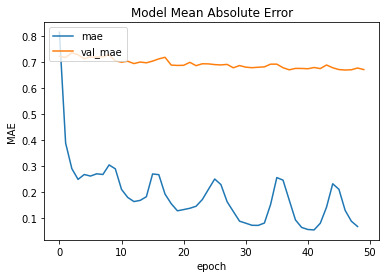

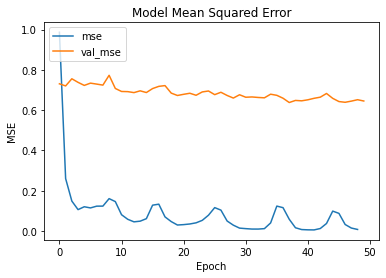

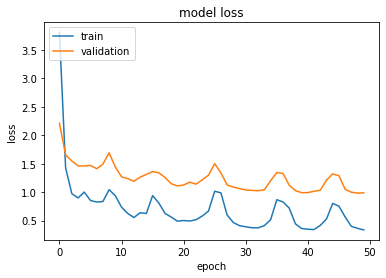

In [13]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['mae', 'val_mae'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['mse', 'val_mse'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Convolutional Neural Network

In [14]:
mse = []
mae = []

model_CNN = Sequential()
model_CNN.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=True))
init_he_u = initializers.he_uniform(seed=None)
#model_CNN.add(Conv1D(128, 5, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
model_CNN.add(Conv1D(25, 5, activation='relu', kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
model_CNN.add(GlobalMaxPooling1D())
model_CNN.add(Dense(25, activation='relu',kernel_initializer=init_he_u, kernel_regularizer=l1(0.001)))
model_CNN.add(Dense(1, activation='relu', kernel_regularizer=l1(0.001)))
model_CNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
history = model_CNN.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=50, batch_size=16, verbose=2)

_,e1,e2 = model_CNN.evaluate(x_test_seq, y_test)
mse.append(e1)
mae.append(e2)

print("mse : ", history.history['mse'].pop())
print("mae : ", history.history['mae'].pop())

    
print('val_mse: ',sum(mse)/len(mse))
print('val_mae: ',sum(mae)/len(mae))

Epoch 1/50
63/63 - 5s - loss: 2.0169 - mse: 0.7320 - mae: 0.7208 - val_loss: 1.9484 - val_mse: 0.7302 - val_mae: 0.7217 - 5s/epoch - 79ms/step
Epoch 2/50
63/63 - 4s - loss: 1.4877 - mse: 0.3328 - mae: 0.4831 - val_loss: 1.7235 - val_mse: 0.6370 - val_mae: 0.6763 - 4s/epoch - 66ms/step
Epoch 3/50
63/63 - 4s - loss: 1.1445 - mse: 0.1254 - mae: 0.2776 - val_loss: 1.5668 - val_mse: 0.6176 - val_mae: 0.6612 - 4s/epoch - 65ms/step
Epoch 4/50
63/63 - 4s - loss: 0.9321 - mse: 0.0532 - mae: 0.1746 - val_loss: 1.3946 - val_mse: 0.5863 - val_mae: 0.6449 - 4s/epoch - 64ms/step
Epoch 5/50
63/63 - 4s - loss: 0.7810 - mse: 0.0364 - mae: 0.1454 - val_loss: 1.2617 - val_mse: 0.5799 - val_mae: 0.6418 - 4s/epoch - 68ms/step
Epoch 6/50
63/63 - 4s - loss: 0.6589 - mse: 0.0311 - mae: 0.1347 - val_loss: 1.1557 - val_mse: 0.5773 - val_mae: 0.6430 - 4s/epoch - 70ms/step
Epoch 7/50
63/63 - 4s - loss: 0.5980 - mse: 0.0545 - mae: 0.1845 - val_loss: 1.1112 - val_mse: 0.5970 - val_mae: 0.6509 - 4s/epoch - 69ms/step

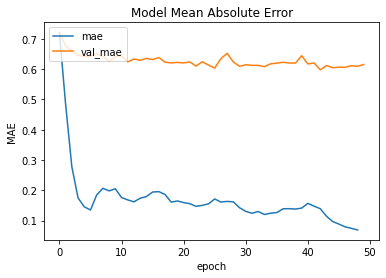

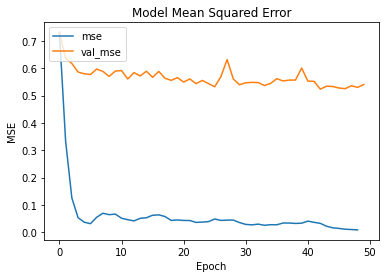

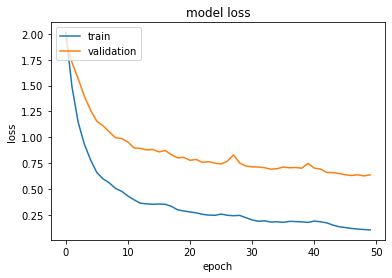

In [15]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['mae', 'val_mae'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['mse', 'val_mse'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Recurrent Neural Network

In [16]:
x_train_seq = pad_sequences(sequences, maxlen=45)
sequences_val = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_val, maxlen=45)
x_test_seq=np.asarray(x_test_seq).astype(np.float32)
x_train_seq=np.asarray(x_train_seq).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)

In [17]:
#Creating embedding matrix - word2Vec
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if word in word2vec_vectors:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
        
print(embedding_matrix.shape)
print(tokenizer.word_index.items())

(5626, 300)
dict_items([('i', 1), ('and', 2), ('the', 3), ('to', 4), ('my', 5), ('it', 6), ('a', 7), ('for', 8), ('was', 9), ('of', 10), ('have', 11), ('this', 12), ('on', 13), ('in', 14), ('me', 15), ('had', 16), ('but', 17), ('with', 18), ('is', 19), ('that', 20), ('not', 21), ('2', 22), ('so', 23), ('been', 24), ('after', 25), ('at', 26), ('day', 27), ('am', 28), ('all', 29), ('taking', 30), ("i'm", 31), ('no', 32), ('3', 33), ('as', 34), ('side', 35), ('about', 36), ('now', 37), ('pain', 38), ("i've", 39), ('started', 40), ('effects', 41), ('first', 42), ('out', 43), ('up', 44), ('has', 45), ('like', 46), ('months', 47), ('very', 48), ('years', 49), ('just', 50), ('get', 51), ('from', 52), ('time', 53), ('take', 54), ('days', 55), ('be', 56), ('if', 57), ('when', 58), ('feel', 59), ('you', 60), ('or', 61), ('would', 62), ('because', 63), ('only', 64), ('back', 65), ('pill', 66), ('one', 67), ('weeks', 68), ('then', 69), ('medication', 70), ('took', 71), ('doctor', 72), ('did', 73),

In [18]:
mse = []
mae = []

model_RNN = Sequential()
e = Embedding(num_words, 300, weights=[embedding_matrix], input_length=45, trainable=True, mask_zero = True)
model_RNN.add(e)
#Recurrent Layer
model_RNN.add(LSTM(64,dropout=0.1, recurrent_dropout=0.1))
model_RNN.add(Dense(25, activation='relu'))
model_RNN.add(Dense(25, activation='relu'))
model_RNN.add(Dense(1, activation='relu'))
opt = tensorflow.optimizers.Adam(learning_rate=0.05)
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
history = model_RNN.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=50, batch_size=16, verbose=2)

_,e1,e2 = model_RNN.evaluate(x_test_seq, y_test)
mse.append(e1)
mae.append(e2)

print("mse : ", history.history['mse'].pop())
print("mae : ", history.history['mae'].pop())

    
print('val_mse: ',sum(mse)/len(mse))
print('val_mae: ',sum(mae)/len(mae))

Epoch 1/50
63/63 - 9s - loss: 1.2050 - mse: 1.2050 - mae: 0.8896 - val_loss: 0.7273 - val_mse: 0.7273 - val_mae: 0.7043 - 9s/epoch - 144ms/step
Epoch 2/50
63/63 - 5s - loss: 0.6393 - mse: 0.6393 - mae: 0.6767 - val_loss: 0.6959 - val_mse: 0.6959 - val_mae: 0.7064 - 5s/epoch - 82ms/step
Epoch 3/50
63/63 - 5s - loss: 0.4793 - mse: 0.4793 - mae: 0.5795 - val_loss: 0.6479 - val_mse: 0.6479 - val_mae: 0.6754 - 5s/epoch - 82ms/step
Epoch 4/50
63/63 - 5s - loss: 0.2741 - mse: 0.2741 - mae: 0.4120 - val_loss: 0.7446 - val_mse: 0.7446 - val_mae: 0.7068 - 5s/epoch - 84ms/step
Epoch 5/50
63/63 - 5s - loss: 0.1475 - mse: 0.1475 - mae: 0.2950 - val_loss: 0.6923 - val_mse: 0.6923 - val_mae: 0.6643 - 5s/epoch - 85ms/step
Epoch 6/50
63/63 - 5s - loss: 0.0887 - mse: 0.0887 - mae: 0.2178 - val_loss: 0.6658 - val_mse: 0.6658 - val_mae: 0.6508 - 5s/epoch - 83ms/step
Epoch 7/50
63/63 - 6s - loss: 0.0537 - mse: 0.0537 - mae: 0.1666 - val_loss: 0.6897 - val_mse: 0.6897 - val_mae: 0.6556 - 6s/epoch - 88ms/ste

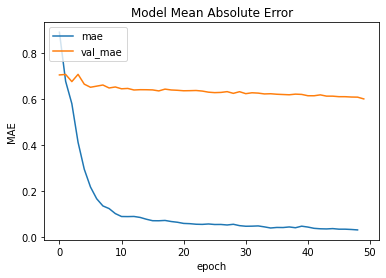

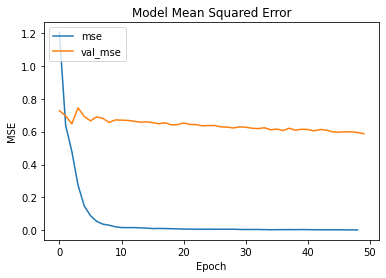

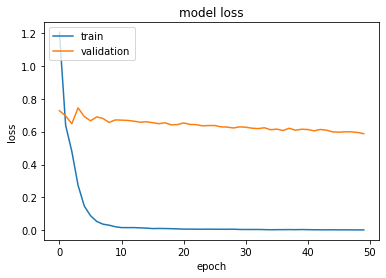

In [19]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['mae', 'val_mae'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['mse', 'val_mse'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Assignment 2 Task 2

## Confusion matrix

y_test shape: (500,)
y_test:
1.0
1.0
1.0
1.0
1.0

 x_test_seq shape: (500, 45)
x_test_seq : 
[3.]
[2.]
[2.]
[3.]
[1.]

 Confusion matrix: 
 [[ 52  96  16]
 [ 24 119  22]
 [ 11  94  66]]


<function matplotlib.pyplot.show(close=None, block=None)>

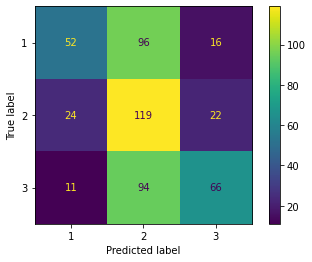

In [20]:
expected = y_test
print('y_test shape:', y_test.shape)
print('y_test:')
for i in range(5):
    print(y_test[i])

print('\n x_test_seq shape:', x_test_seq.shape)
pred = model_RNN.predict(x_test_seq)
print('x_test_seq : ')
for i in range(5):
    print(np.round(pred[i]))
    


results = confusion_matrix(expected, np.round(pred))
print('\n Confusion matrix: \n', results)
disp = ConfusionMatrixDisplay(confusion_matrix=results, display_labels={1,2,3})
disp.plot()
plt.show

## 3-class  classification  problem: RNN

In [21]:
# Creating features and labels vectors
x_train_class = []
y_train_class = []
train_length = 45

for row in sequences:
    for i in range(train_length, len(row)):
        sequence = row[i-train_length:i+1] 
        x_train_class.append(sequence[:-1])
        y_train_class.append(sequence[-1])
x_train_class = np.array(x_train_class)
y_train_class = np.array(y_train_class)
print(x_train_class.shape)
print(len(y_train_class))

x_test_class = []
y_test_class = []
train_length = 45

for row in sequences_val:
    for i in range(train_length, len(row)):
        sequences = row[i-train_length:i+1]       
        x_test_class.append(sequence[:-1])
        y_test_class.append(sequence[-1])
x_test_class = np.array(x_test_class)
y_test_class = np.array(y_test_class)
print(x_test_class.shape)
print(len(y_test_class))

(41040, 45)
41040
(19880, 45)
19880


In [22]:
#One-hot encoding the labels
y_train_array = np.zeros((len(y_train_class), num_words),dtype=int)
for idx,word_idx in enumerate(y_train_class):
    y_train_array[idx,word_idx] = 1
    
y_test_array = np.zeros((len(y_test_class), num_words),dtype=int)
for idx,word_idx in enumerate(y_test_class):
    y_test_array[idx,word_idx] = 1

In [ ]:
#Create model
model = Sequential()
model.add(Embedding(input_dim=num_words,
              input_length = train_length,
              output_dim=300,
              weights=[embedding_matrix],
              trainable=False,
              mask_zero=True))

# Recurrent layer
model.add(LSTM(64,dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_words, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_class,  y_train_array, batch_size=64, epochs=15, validation_data=(x_test_class, y_test_array))

Epoch 1/15
642/642 [==============================] - 86s 129ms/step - loss: 6.5429 - accuracy: 0.0505 - val_loss: 11.9829 - val_accuracy: 0.0000e+00
Epoch 2/15
642/642 [==============================] - 83s 129ms/step - loss: 6.2487 - accuracy: 0.0564 - val_loss: 12.0017 - val_accuracy: 0.0000e+00
Epoch 3/15
642/642 [==============================] - 83s 129ms/step - loss: 6.1500 - accuracy: 0.0641 - val_loss: 11.7737 - val_accuracy: 0.0000e+00
Epoch 4/15
642/642 [==============================] - 82s 129ms/step - loss: 6.0415 - accuracy: 0.0737 - val_loss: 11.7659 - val_accuracy: 0.0000e+00
Epoch 5/15
518/642 [=======================>......] - ETA: 14s - loss: 5.9329 - accuracy: 0.0787

In [ ]:
expected = y_test_array
print('y_test_array shape:', y_test_array.shape)
print('y_test_array:')
for i in range(5):
    print(y_test_array[i])

print('\n x_test_class shape:', x_test_class.shape)
pred = model_RNN.predict(x_test_class)
print('x_test_class : ')
for i in range(5):
    print(np.round(pred[i]))

results = confusion_matrix(expected, np.round(pred))
print('\n Confusion matrix: \n', results)
disp = ConfusionMatrixDisplay(confusion_matrix=results, display_labels={1,2,3})
disp.plot()
plt.show